In [18]:
import os
import glob
import pickle
import numpy as np
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import rbf_kernel as rbf
from sklearn.metrics.pairwise import polynomial_kernel as poly
from sklearn.metrics.pairwise import linear_kernel as linear
from tqdm.auto import tqdm
import torch
import torch.autograd as autograd

import matplotlib.pylab as plt
%matplotlib inline

plt.style.use('seaborn-v0_8-colorblind')
import warnings
warnings.filterwarnings('ignore')

In [36]:
def cumulative_mean(dist_list):
    """Compute cumulative mean of a list"""
    if len(dist_list) == 0:
        return np.array([])
    cum_sum = np.cumsum(dist_list, 0)
    for i in range(len(cum_sum)):
        cum_sum[i] /= (i+1)
    return cum_sum

def load_results_from_pickle(results_path, pattern="svgd_results_*.pkl", target_iterations=5000):
    """Load all experiment results from pickle files (指定したiterationのみ)"""
    results = {}
    for filename in glob.glob(os.path.join(results_path, pattern)):
        # 5000iterationのファイルのみ読み込む
        if f"_iter{target_iterations}.pkl" not in filename:
            continue
        with open(filename, 'rb') as f:
            result = pickle.load(f)
        # ファイル名からパラメータ抽出
        filename_parts = os.path.basename(filename).replace('.pkl', '').split('_')
        n_particles = None
        decay_beta = None
        for part in filename_parts:
            if part.startswith('n'):
                n_particles = int(part[1:])
            elif part.startswith('beta'):
                decay_beta = float(part[4:])
        if n_particles is not None and decay_beta is not None:
            key = f"n{n_particles}_beta{decay_beta}"
            results[key] = result
            print(f"Loaded: {filename} -> {key}")
    return results

# Extract data from results for different beta values and particle counts
# This code extracts kl_kde_list, ksd_list, and eig_list from the results dictionary

def extract_data_from_results(results, particle_count=5):
    """
    Extract data from results dictionary for a specific particle count
    
    Parameters:
    -----------
    results : dict
        Results dictionary loaded from pickle files
    particle_count : int
        Number of particles to extract data for
    
    Returns:
    --------
    dict : Dictionary containing extracted data for different beta values
    """
    
    extracted_data = {}
    beta_values = [0.0, 0.5, 0.67, 1.0]
    
    for beta in beta_values:
        key = f"n{particle_count}_beta{beta}"
        if key in results:
            data = results[key]
            
            # Extract KDE-KL (replacing the old Gaussian KL)
            kl_kde_list = data.get('kl_kde_list', None)
            if kl_kde_list is not None:
                # Remove NaN values and get valid data
                valid_kl = kl_kde_list.flatten()[~np.isnan(kl_kde_list.flatten())]
            else:
                valid_kl = np.array([])
            
            # Extract KSD
            ksd_list = data.get('ksd_list', None)
            if ksd_list is not None:
                ksd_data = ksd_list.flatten()
            else:
                ksd_data = np.array([])
            
            # Extract eigenvalues
            eig_list = data.get('eig_list', None)
            if eig_list is not None:
                eig_data = eig_list
            else:
                eig_data = np.array([])
            
            # Store extracted data
            extracted_data[f'beta_{beta}'] = {
                'kl_kde': valid_kl,
                'ksd': ksd_data,
                'eig': eig_data
            }
            
            print(f"Extracted data for {key}:")
            print(f"  KDE-KL shape: {valid_kl.shape}")
            print(f"  KSD shape: {ksd_data.shape}")
            print(f"  Eigenvalues shape: {eig_data.shape}")
        else:
            print(f"Warning: Key {key} not found in results")
    
    return extracted_data

# Optional: Extract data for other particle counts
def extract_all_particle_data(results):
    """Extract data for all particle counts"""
    particle_counts = [5, 10, 20, 50]
    all_data = {}
    
    for n_particles in particle_counts:
        all_data[n_particles] = extract_data_from_results(results, particle_count=n_particles)
    
    return all_data

In [37]:
# Set up paths
path = os.getcwd()
results_path = path + '/results/'

print(f"Results path: {results_path}")
print(f"Results path exists: {os.path.exists(results_path)}")

Results path: /Users/fujisawa/research_code/svgd_convergence/BLR/results/
Results path exists: True


# Import results

In [38]:
# Load all results
results = load_results_from_pickle(results_path, target_iterations=5000)
print(f"Loaded {len(results)} experiment results")

# Print available experiments
for key in sorted(results.keys()):
    print(f"  {key}")

Loaded: /Users/fujisawa/research_code/svgd_convergence/BLR/results/svgd_results_n5_beta0.5_iter5000.pkl -> n5_beta0.5
Loaded: /Users/fujisawa/research_code/svgd_convergence/BLR/results/svgd_results_n10_beta0.5_iter5000.pkl -> n10_beta0.5
Loaded: /Users/fujisawa/research_code/svgd_convergence/BLR/results/svgd_results_n20_beta1.0_iter5000.pkl -> n20_beta1.0
Loaded: /Users/fujisawa/research_code/svgd_convergence/BLR/results/svgd_results_n20_beta0.0_iter5000.pkl -> n20_beta0.0
Loaded: /Users/fujisawa/research_code/svgd_convergence/BLR/results/svgd_results_n50_beta0.5_iter5000.pkl -> n50_beta0.5
Loaded: /Users/fujisawa/research_code/svgd_convergence/BLR/results/svgd_results_n20_beta0.5_iter5000.pkl -> n20_beta0.5
Loaded: /Users/fujisawa/research_code/svgd_convergence/BLR/results/svgd_results_n50_beta0.0_iter5000.pkl -> n50_beta0.0
Loaded: /Users/fujisawa/research_code/svgd_convergence/BLR/results/svgd_results_n50_beta1.0_iter5000.pkl -> n50_beta1.0
Loaded: /Users/fujisawa/research_code/svgd

In [ ]:
# Optional: Extract data for other particle counts
def extract_all_particle_data(results):
    """Extract data for all particle counts"""
    particle_counts = [5, 10, 20, 50]
    all_data = {}
    
    for n_particles in particle_counts:
        all_data[n_particles] = extract_data_from_results(results, particle_count=n_particles)
    
    return all_data

# Uncomment the following line if you want data for all particle counts
# all_particle_data = extract_all_particle_data(results)

In [22]:
all_data = extract_all_particle_data(results)

Extracted data for n5_beta0.0:
  KDE-KL shape: (5000,)
  KSD shape: (5000,)
  Eigenvalues shape: (3, 5)
Extracted data for n5_beta0.5:
  KDE-KL shape: (5000,)
  KSD shape: (5000,)
  Eigenvalues shape: (3, 5)
Extracted data for n5_beta0.67:
  KDE-KL shape: (5000,)
  KSD shape: (5000,)
  Eigenvalues shape: (3, 5)
Extracted data for n5_beta1.0:
  KDE-KL shape: (5000,)
  KSD shape: (5000,)
  Eigenvalues shape: (3, 5)
Extracted data for n10_beta0.0:
  KDE-KL shape: (5000,)
  KSD shape: (5000,)
  Eigenvalues shape: (3, 10)
Extracted data for n10_beta0.5:
  KDE-KL shape: (5000,)
  KSD shape: (5000,)
  Eigenvalues shape: (3, 10)
Extracted data for n10_beta0.67:
  KDE-KL shape: (5000,)
  KSD shape: (5000,)
  Eigenvalues shape: (3, 10)
Extracted data for n10_beta1.0:
  KDE-KL shape: (5000,)
  KSD shape: (5000,)
  Eigenvalues shape: (3, 10)
Extracted data for n20_beta0.0:
  KDE-KL shape: (5000,)
  KSD shape: (5000,)
  Eigenvalues shape: (3, 20)
Extracted data for n20_beta0.5:
  KDE-KL shape: (500

# Results plot

## Step size sensitivity

In [47]:
kl_rbf_5, ksd_rbf_5, eig_rbf_5 = all_data[5]['beta_0.0']['kl_kde'], all_data[5]['beta_0.0']['ksd'], all_data[5]['beta_0.0']['eig']
kl_rbf_67_5, ksd_rbf_67_5, eig_rbf_67_5 = all_data[5]['beta_0.67']['kl_kde'], all_data[5]['beta_0.67']['ksd'], all_data[5]['beta_0.67']['eig']
kl_rbf_sqrt_5, ksd_rbf_sqrt_5, eig_rbf_sqrt_5 = all_data[5]['beta_0.5']['kl_kde'], all_data[5]['beta_0.5']['ksd'], all_data[5]['beta_0.5']['eig']
kl_rbf_1_5, ksd_rbf_1_5, eig_rbf_1_5 = all_data[5]['beta_1.0']['kl_kde'], all_data[5]['beta_1.0']['ksd'], all_data[5]['beta_1.0']['eig']

cum_kl_rbf_5, cum_ksd_rbf_5 = cumulative_mean(kl_rbf_5), cumulative_mean(ksd_rbf_5)
cum_kl_rbf_67_5, cum_ksd_rbf_67_5 = cumulative_mean(kl_rbf_67_5), cumulative_mean(ksd_rbf_67_5)
cum_kl_rbf_sqrt_5, cum_ksd_rbf_sqrt_5 = cumulative_mean(kl_rbf_sqrt_5), cumulative_mean(ksd_rbf_sqrt_5)
cum_kl_rbf_1_5, cum_ksd_rbf_1_5 = cumulative_mean(kl_rbf_1_5), cumulative_mean(ksd_rbf_1_5)

In [48]:
kl_rbf_10, ksd_rbf_10, eig_rbf_10 = all_data[10]['beta_0.0']['kl_kde'], all_data[10]['beta_0.0']['ksd'], all_data[10]['beta_0.0']['eig']
kl_rbf_67_10, ksd_rbf_67_10, eig_rbf_67_10 = all_data[10]['beta_0.67']['kl_kde'], all_data[10]['beta_0.67']['ksd'], all_data[10]['beta_0.67']['eig']
kl_rbf_sqrt_10, ksd_rbf_sqrt_10, eig_rbf_sqrt_10 = all_data[10]['beta_0.5']['kl_kde'], all_data[10]['beta_0.5']['ksd'], all_data[10]['beta_0.5']['eig']
kl_rbf_1_10, ksd_rbf_1_10, eig_rbf_1_10 = all_data[10]['beta_1.0']['kl_kde'], all_data[10]['beta_1.0']['ksd'], all_data[10]['beta_1.0']['eig']

cum_kl_rbf_10, cum_ksd_rbf_10 = cumulative_mean(kl_rbf_10), cumulative_mean(ksd_rbf_10)
cum_kl_rbf_67_10, cum_ksd_rbf_67_10 = cumulative_mean(kl_rbf_67_10), cumulative_mean(ksd_rbf_67_10)
cum_kl_rbf_sqrt_10, cum_ksd_rbf_sqrt_10 = cumulative_mean(kl_rbf_sqrt_10), cumulative_mean(ksd_rbf_sqrt_10)
cum_kl_rbf_1_10, cum_ksd_rbf_1_10 = cumulative_mean(kl_rbf_1_10), cumulative_mean(ksd_rbf_1_10)

In [49]:
kl_rbf_20, ksd_rbf_20, eig_rbf_20 = all_data[20]['beta_0.0']['kl_kde'], all_data[20]['beta_0.0']['ksd'], all_data[20]['beta_0.0']['eig']
kl_rbf_67_20, ksd_rbf_67_20, eig_rbf_67_20 = all_data[20]['beta_0.67']['kl_kde'], all_data[20]['beta_0.67']['ksd'], all_data[20]['beta_0.67']['eig']
kl_rbf_sqrt_20, ksd_rbf_sqrt_20, eig_rbf_sqrt_20 = all_data[20]['beta_0.5']['kl_kde'], all_data[20]['beta_0.5']['ksd'], all_data[20]['beta_0.5']['eig']
kl_rbf_1_20, ksd_rbf_1_20, eig_rbf_1_20 = all_data[20]['beta_1.0']['kl_kde'], all_data[20]['beta_1.0']['ksd'], all_data[20]['beta_1.0']['eig']

cum_kl_rbf_20, cum_ksd_rbf_20 = cumulative_mean(kl_rbf_20), cumulative_mean(ksd_rbf_20)
cum_kl_rbf_67_20, cum_ksd_rbf_67_20 = cumulative_mean(kl_rbf_67_20), cumulative_mean(ksd_rbf_67_20)
cum_kl_rbf_sqrt_20, cum_ksd_rbf_sqrt_20 = cumulative_mean(kl_rbf_sqrt_20), cumulative_mean(ksd_rbf_sqrt_20)
cum_kl_rbf_1_20, cum_ksd_rbf_1_20 = cumulative_mean(kl_rbf_1_20), cumulative_mean(ksd_rbf_1_20)

In [50]:
kl_rbf_50, ksd_rbf_50, eig_rbf_50 = all_data[50]['beta_0.0']['kl_kde'], all_data[50]['beta_0.0']['ksd'], all_data[50]['beta_0.0']['eig']
kl_rbf_67_50, ksd_rbf_67_50, eig_rbf_67_50 = all_data[50]['beta_0.67']['kl_kde'], all_data[50]['beta_0.67']['ksd'], all_data[50]['beta_0.67']['eig']
kl_rbf_sqrt_50, ksd_rbf_sqrt_50, eig_rbf_sqrt_50 = all_data[50]['beta_0.5']['kl_kde'], all_data[50]['beta_0.5']['ksd'], all_data[50]['beta_0.5']['eig']
kl_rbf_1_50, ksd_rbf_1_50, eig_rbf_1_50 = all_data[50]['beta_1.0']['kl_kde'], all_data[50]['beta_1.0']['ksd'], all_data[50]['beta_1.0']['eig']

cum_kl_rbf_50, cum_ksd_rbf_50 = cumulative_mean(kl_rbf_50), cumulative_mean(ksd_rbf_50)
cum_kl_rbf_67_50, cum_ksd_rbf_67_50 = cumulative_mean(kl_rbf_67_50), cumulative_mean(ksd_rbf_67_50)
cum_kl_rbf_sqrt_50, cum_ksd_rbf_sqrt_50 = cumulative_mean(kl_rbf_sqrt_50), cumulative_mean(ksd_rbf_sqrt_50)
cum_kl_rbf_1_50, cum_ksd_rbf_1_50 = cumulative_mean(kl_rbf_1_50), cumulative_mean(ksd_rbf_1_50)

Text(0.5, 0, 'iterations')

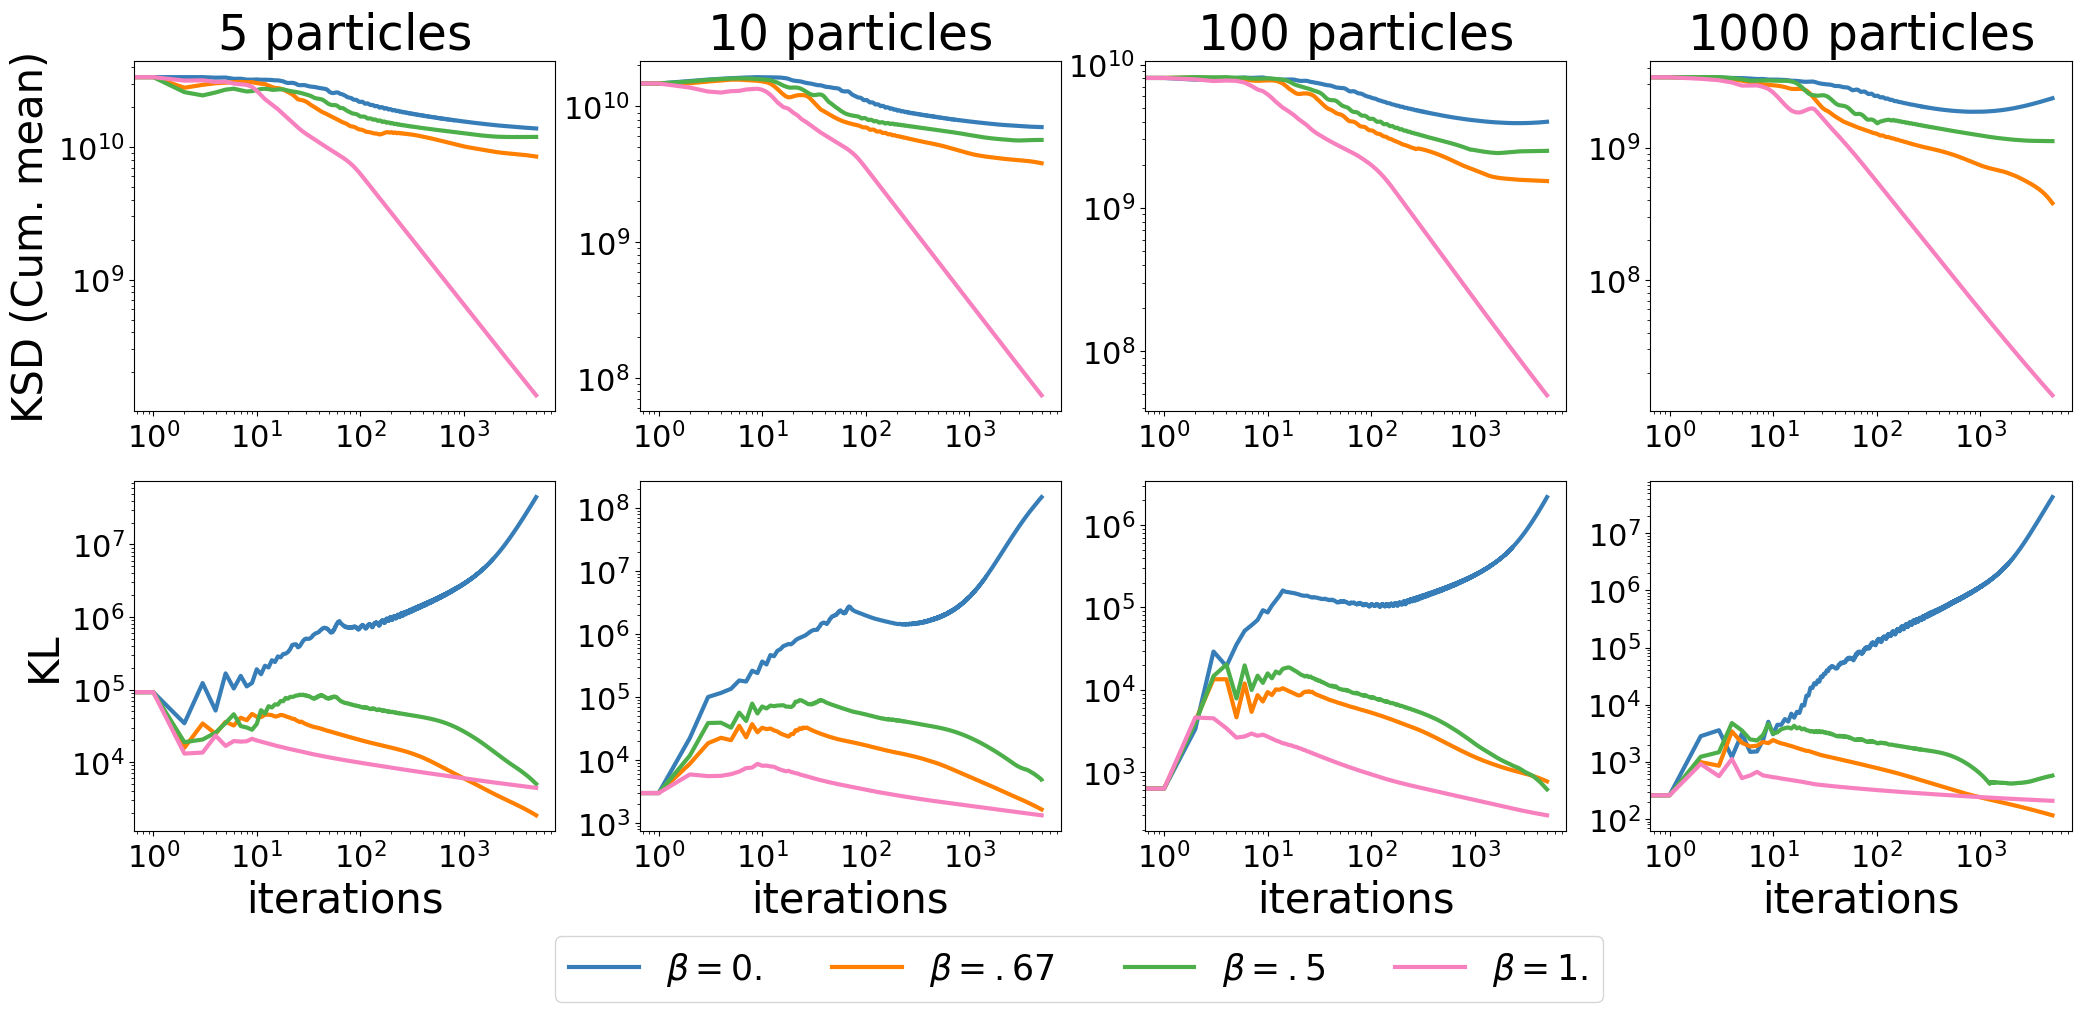

In [52]:
plt.figure(figsize=(25,10))

plt.subplot(2,4,1)
plt.plot(cum_ksd_rbf_5, label=r'$\beta=0.$',linewidth=3,c='#377eb8')
plt.plot(cum_ksd_rbf_67_5, label=r'$\beta=.67$',linewidth=3,c='#ff7f00')
plt.plot(cum_ksd_rbf_sqrt_5, label=r'$\beta=.5$',linewidth=3,c='#4daf4a')
plt.plot(cum_ksd_rbf_1_5, label=r'$\beta=1.$',linewidth=3,c='#f781bf')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('KSD (Cum. mean)',fontsize=30)
plt.title('$5$ particles',fontsize=35)
plt.legend(bbox_to_anchor=(1, -1.5), loc='upper left', borderaxespad=0, fontsize=25, ncol = 4)

plt.subplot(2,4,2)
plt.plot(cum_ksd_rbf_10, label='$\beta=0.$',linewidth=3,c='#377eb8')
plt.plot(cum_ksd_rbf_67_10, label='$\beta=.67$',linewidth=3,c='#ff7f00')
plt.plot(cum_ksd_rbf_sqrt_10, label='$\beta=.5$',linewidth=3,c='#4daf4a')
plt.plot(cum_ksd_rbf_1_10, label='$\beta=1.$',linewidth=3,c='#f781bf')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title('$10$ particles',fontsize=35)


plt.subplot(2,4,3)
plt.plot(cum_ksd_rbf_20, label='$\beta=1.$',linewidth=3,c='#377eb8')
plt.plot(cum_ksd_rbf_67_20, label='$\beta=.75$',linewidth=3,c='#ff7f00')
plt.plot(cum_ksd_rbf_sqrt_20, label='$\beta=.5$',linewidth=3,c='#4daf4a')
plt.plot(cum_ksd_rbf_1_20, label='$\beta=.25$',linewidth=3,c='#f781bf')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title('$100$ particles',fontsize=35)

plt.subplot(2,4,4)
plt.plot(cum_ksd_rbf_50, label='$\beta=1.$',linewidth=3,c='#377eb8')
plt.plot(cum_ksd_rbf_67_50, label='$\beta=.75$',linewidth=3,c='#ff7f00')
plt.plot(cum_ksd_rbf_sqrt_50, label='$\beta=.5$',linewidth=3,c='#4daf4a')
plt.plot(cum_ksd_rbf_1_50, label='$\beta=.25$',linewidth=3,c='#f781bf')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title('$1000$ particles',fontsize=35)

plt.subplot(2,4,5)
plt.plot(kl_rbf_5, label='$\beta=1.$',linewidth=3,c='#377eb8')
plt.plot(kl_rbf_67_5, label='$\beta=.75$',linewidth=3,c='#ff7f00')
plt.plot(kl_rbf_sqrt_5, label='$\beta=.5$',linewidth=3,c='#4daf4a')
plt.plot(kl_rbf_1_5, label='$\beta=.25$',linewidth=3,c='#f781bf')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('iterations',fontsize=30)
plt.ylabel('KL',fontsize=30)

plt.subplot(2,4,6)
plt.plot(kl_rbf_10, label='$\beta=1.$',linewidth=3,c='#377eb8')
plt.plot(kl_rbf_67_10, label='$\beta=.75$',linewidth=3,c='#ff7f00')
plt.plot(kl_rbf_sqrt_10, label='$\beta=.5$',linewidth=3,c='#4daf4a')
plt.plot(kl_rbf_1_10, label='$\beta=.25$',linewidth=3,c='#f781bf')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('iterations',fontsize=30)


plt.subplot(2,4,7)
plt.plot(kl_rbf_20, label='$\beta=1.$',linewidth=3,c='#377eb8')
plt.plot(kl_rbf_67_20, label='$\beta=.75$',linewidth=3,c='#ff7f00')
plt.plot(kl_rbf_sqrt_20, label='$\beta=.5$',linewidth=3,c='#4daf4a')
plt.plot(kl_rbf_1_20, label='$\beta=.25$',linewidth=3,c='#f781bf')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('iterations',fontsize=30)

plt.subplot(2,4,8)
plt.plot(kl_rbf_50, label='$\beta=1.$',linewidth=3,c='#377eb8')
plt.plot(kl_rbf_67_50, label='$\beta=.75$',linewidth=3,c='#ff7f00')
plt.plot(kl_rbf_sqrt_50, label='$\beta=.5$',linewidth=3,c='#4daf4a')
plt.plot(kl_rbf_1_50, label='$\beta=.25$',linewidth=3,c='#f781bf')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('iterations',fontsize=30)

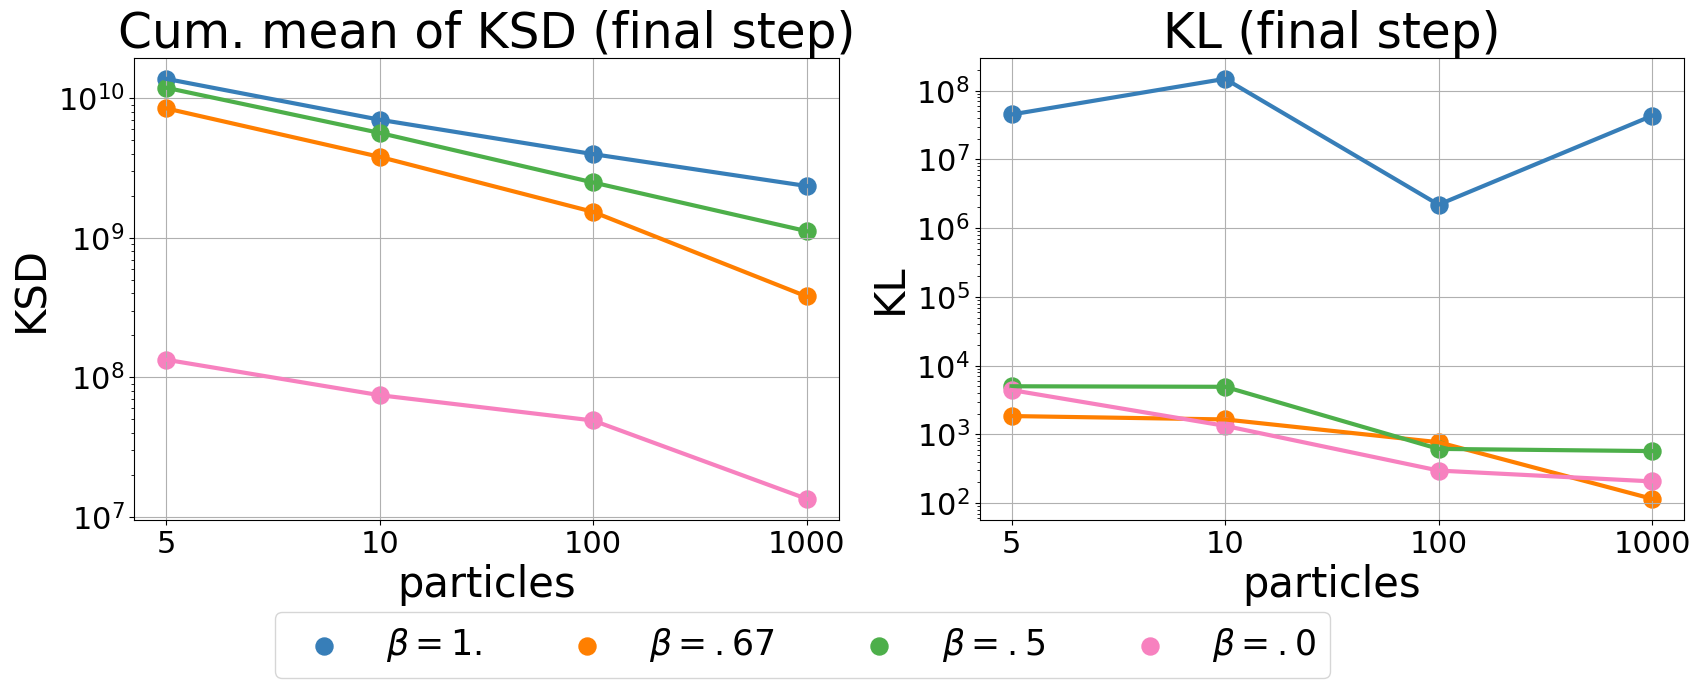

In [54]:
plt.figure(figsize=(20,6))
particles_list = [5, 10, 100, 1000]

plt.subplot(1,2,1)
ksd_rbf_1 = [cum_ksd_rbf_5[-1], cum_ksd_rbf_10[-1], cum_ksd_rbf_20[-1], cum_ksd_rbf_50[-1]]
ksd_rbf_67 = [cum_ksd_rbf_67_5[-1], cum_ksd_rbf_67_10[-1], cum_ksd_rbf_67_20[-1], cum_ksd_rbf_67_50[-1]]
ksd_rbf_sqrt = [cum_ksd_rbf_sqrt_5[-1], cum_ksd_rbf_sqrt_10[-1], cum_ksd_rbf_sqrt_20[-1], cum_ksd_rbf_sqrt_50[-1]]
ksd_rbf_0 = [cum_ksd_rbf_1_5[-1], cum_ksd_rbf_1_10[-1], cum_ksd_rbf_1_20[-1], cum_ksd_rbf_1_50[-1]]

x = range(len(particles_list))
plt.scatter(x, ksd_rbf_1, s=150, label='Final KSD w./ RBF',c='#377eb8')
plt.plot(x, ksd_rbf_1, linewidth=3,c='#377eb8')
plt.scatter(x, ksd_rbf_67, s=150, label='Final KSD w./ linear',c='#ff7f00')
plt.plot(x, ksd_rbf_67, linewidth=3,c='#ff7f00')
plt.scatter(x, ksd_rbf_sqrt, s=150, label='Final KSD w./ linear',c='#4daf4a')
plt.plot(x, ksd_rbf_sqrt, linewidth=3,c='#4daf4a')
plt.scatter(x, ksd_rbf_0, s=150, label='Final KSD w./ linear',c='#f781bf')
plt.plot(x, ksd_rbf_0, linewidth=3,c='#f781bf')
plt.xticks(x, particles_list)
plt.grid(True)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('particles',fontsize=30)
plt.yscale('log')
plt.ylabel('KSD',fontsize=30)
#plt.legend(fontsize=22)
plt.title('Cum. mean of KSD (final step)',fontsize=35)

plt.subplot(1,2,2)

kl_rbf_1 = [kl_rbf_5[-1], kl_rbf_10[-1], kl_rbf_20[-1], kl_rbf_50[-1]]
kl_rbf_67 = [kl_rbf_67_5[-1], kl_rbf_67_10[-1], kl_rbf_67_20[-1], kl_rbf_67_50[-1]]
kl_rbf_sqrt = [kl_rbf_sqrt_5[-1], kl_rbf_sqrt_10[-1], kl_rbf_sqrt_20[-1], kl_rbf_sqrt_50[-1]]
kl_rbf_0 = [kl_rbf_1_5[-1], kl_rbf_1_10[-1], kl_rbf_1_20[-1], kl_rbf_1_50[-1]]

x = range(len(particles_list))
plt.scatter(x, kl_rbf_1, s=150, label=r'$\beta=1.$',c='#377eb8')
plt.plot(x, kl_rbf_1, linewidth=3,c='#377eb8')
plt.scatter(x, kl_rbf_67, s=150, label=r'$\beta=.67$',c='#ff7f00')
plt.plot(x, kl_rbf_67, linewidth=3,c='#ff7f00')
plt.scatter(x, kl_rbf_sqrt, s=150, label=r'$\beta=.5$',c='#4daf4a')
plt.plot(x, kl_rbf_sqrt, linewidth=3,c='#4daf4a')
plt.scatter(x, kl_rbf_0, s=150, label=r'$\beta=.0$',c='#f781bf')
plt.plot(x, kl_rbf_0, linewidth=3,c='#f781bf')
plt.xticks(x, particles_list)
plt.grid(True)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('particles',fontsize=30)
plt.yscale('log')
plt.ylabel('KL',fontsize=30)
#plt.legend(fontsize=22)
plt.title('KL (final step)',fontsize=35)
plt.legend(bbox_to_anchor=(-1, -0.2), loc='upper left', borderaxespad=0, fontsize=25, ncol = 4)

## Eigenvalues

In [11]:
kl_rbf_5, ksd_rbf_5, eig_rbf_5 = np.load(results_path+'kl_rbf_0.67_5.npy'), np.load(results_path+'ksd_rbf_0.67_5.npy'), np.load(results_path+'eig_rbf_0.67_5.npy')
kl_rbf_10, ksd_rbf_10, eig_rbf_10 = np.load(results_path+'kl_rbf_0.67_10.npy'), np.load(results_path+'ksd_rbf_0.67_10.npy'), np.load(results_path+'eig_rbf_0.67_10.npy')
kl_rbf_100, ksd_rbf_100, eig_rbf_100 = np.load(results_path+'kl_rbf_0.67_100.npy'), np.load(results_path+'ksd_rbf_0.67_100.npy'), np.load(results_path+'eig_rbf_0.67_100.npy')
kl_rbf_1000, ksd_rbf_1000, eig_rbf_1000 = np.load(results_path+'kl_rbf_0.67_1000.npy'), np.load(results_path+'ksd_rbf_0.67_1000.npy'), np.load(results_path+'eig_rbf_0.67_1000.npy')

cum_kl_rbf_5, cum_ksd_rbf_5 = cumulative_mean(kl_rbf_5), cumulative_mean(ksd_rbf_5)
cum_kl_rbf_10, cum_ksd_rbf_10 = cumulative_mean(kl_rbf_10), cumulative_mean(ksd_rbf_10)
cum_kl_rbf_100, cum_ksd_rbf_100 = cumulative_mean(kl_rbf_100), cumulative_mean(ksd_rbf_100)
cum_kl_rbf_1000, cum_ksd_rbf_1000 = cumulative_mean(kl_rbf_1000), cumulative_mean(ksd_rbf_1000)

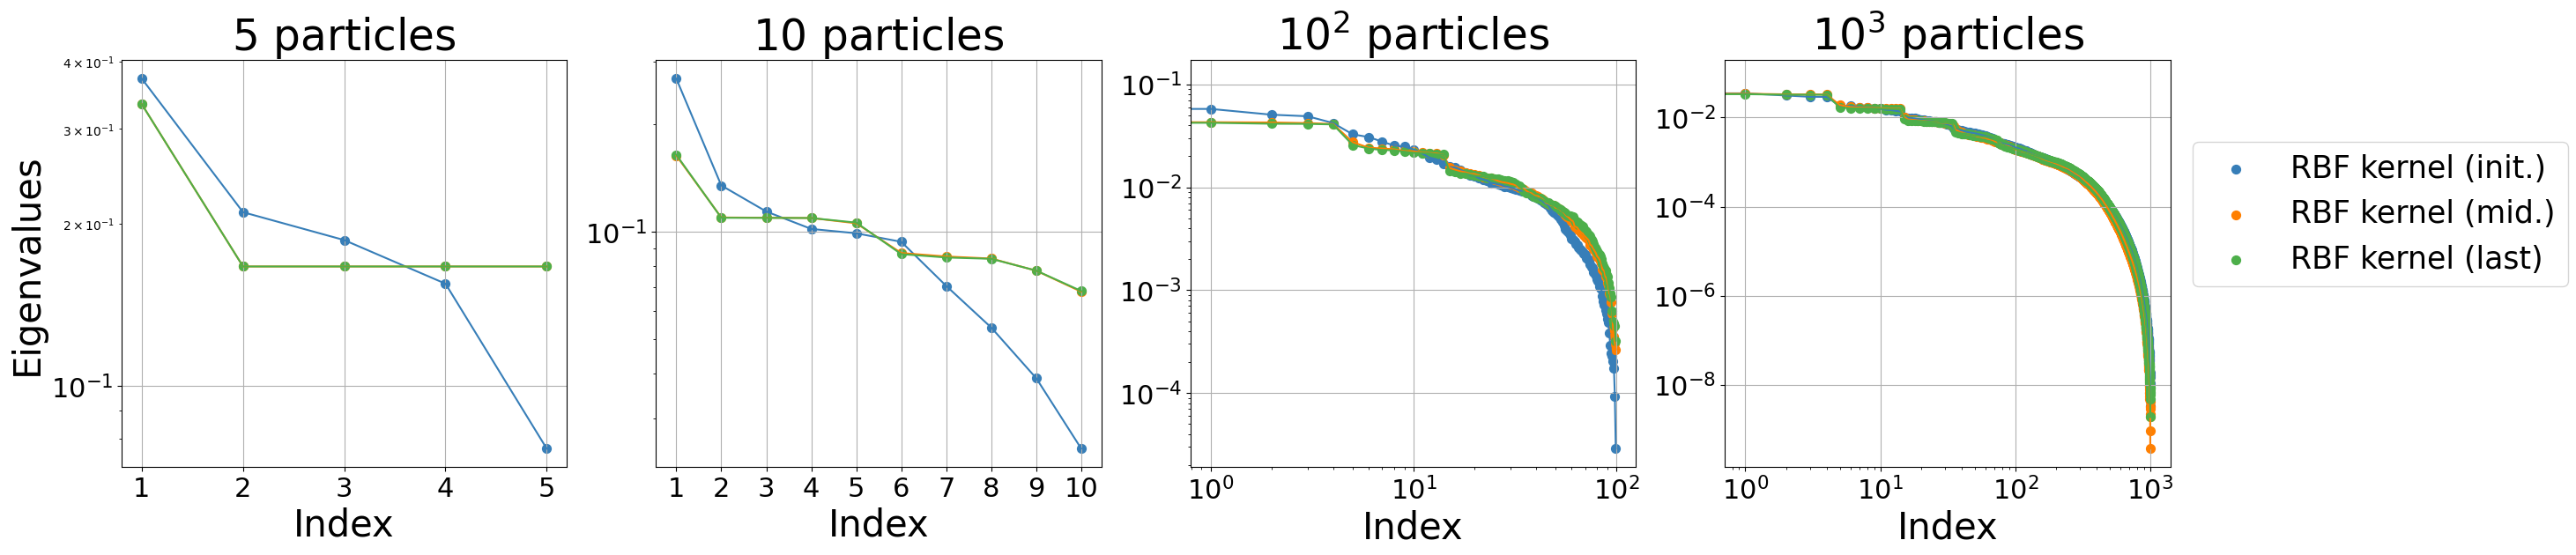

In [12]:
plt.figure(figsize=(30,6))

plt.subplot(1,4,1)
particles_list = np.arange(1,6,1)
x = range(len(particles_list))
p = eig_rbf_5[0].shape

plt.scatter(x, eig_rbf_5[0]/p, s=50, c='#377eb8')
plt.plot(x, eig_rbf_5[0]/p, c='#377eb8')
plt.scatter(x, eig_rbf_5[1]/p, s=50, c='#ff7f00')
plt.plot(x, eig_rbf_5[1]/p, c='#ff7f00')
plt.scatter(x, eig_rbf_5[2]/p, s=50, c='#4daf4a')
plt.plot(x, eig_rbf_5[2]/p, c='#4daf4a')

plt.yscale('log')
#plt.xscale('log')
plt.xticks(x, particles_list)
plt.grid(True)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Index',fontsize=30)
plt.ylabel('Eigenvalues',fontsize=30)
plt.title('$5$ particles',fontsize=35)

plt.subplot(1,4,2)
particles_list = np.arange(1,11,1)
x = range(len(particles_list))
p = eig_rbf_10[0].shape


plt.scatter(x, eig_rbf_10[0]/p, s=50, c='#377eb8')
plt.plot(x, eig_rbf_10[0]/p, c='#377eb8')
plt.scatter(x, eig_rbf_10[1]/p, s=50, c='#ff7f00')
plt.plot(x, eig_rbf_10[1]/p, c='#ff7f00')
plt.scatter(x, eig_rbf_10[2]/p, s=50, c='#4daf4a')
plt.plot(x, eig_rbf_10[2]/p, c='#4daf4a')

plt.yscale('log')
#plt.xscale('log')
plt.xticks(x, particles_list)
plt.grid(True)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Index',fontsize=30)
plt.title('$10$ particles',fontsize=35)

plt.subplot(1,4,3)
particles_list = np.arange(1,101,1)
x = range(len(particles_list))
p = eig_rbf_100[0].shape


plt.scatter(x, eig_rbf_100[0]/p, s=50, c='#377eb8')
plt.plot(x, eig_rbf_100[0]/p, c='#377eb8')
plt.scatter(x, eig_rbf_100[1]/p, s=50, c='#ff7f00')
plt.plot(x, eig_rbf_100[1]/p, c='#ff7f00')
plt.scatter(x, eig_rbf_100[2]/p, s=50, c='#4daf4a')
plt.plot(x, eig_rbf_100[2]/p, c='#4daf4a')

plt.xticks(x, particles_list)
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Index',fontsize=30)
plt.title('$10^{2}$ particles',fontsize=35)

plt.subplot(1,4,4)
particles_list = np.arange(1,1001,1)
x = range(len(particles_list))
p = eig_rbf_1000[0].shape

plt.scatter(x, eig_rbf_1000[0]/p, s=50, c='#377eb8', label='RBF kernel (init.)')
plt.plot(x, eig_rbf_1000[0]/p, c='#377eb8')
plt.scatter(x, eig_rbf_1000[1]/p, s=50, c='#ff7f00', label='RBF kernel (mid.)')
plt.plot(x, eig_rbf_1000[1]/p, c='#ff7f00')
plt.scatter(x, eig_rbf_1000[2]/p, s=50, c='#4daf4a', label='RBF kernel (last)')
plt.plot(x, eig_rbf_1000[2]/p, c='#4daf4a')

plt.xticks(x, particles_list)
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Index',fontsize=30)
plt.title('$10^{3}$ particles',fontsize=35)
plt.legend(bbox_to_anchor=(1.05, 0.8), loc='upper left', borderaxespad=0, fontsize=25, ncol = 1)

In [13]:
e_5 = [max(eig_rbf_5[0]/5), max(eig_rbf_5[1]/5), max(eig_rbf_5[2]/5)]
e_10 = [max(eig_rbf_10[0]/10), max(eig_rbf_10[1]/10), max(eig_rbf_10[2]/10)]
e_100 = [max(eig_rbf_100[0]/100), max(eig_rbf_100[1]/100), max(eig_rbf_100[2]/100)]
e_1000 = [max(eig_rbf_1000[0]/1000), max(eig_rbf_1000[1]/1000), max(eig_rbf_1000[2]/1000)]

e_5_min = [min(eig_rbf_5[0]/5), min(eig_rbf_5[1]/5), min(eig_rbf_5[2]/5)]
e_10_min = [min(eig_rbf_10[0]/10), min(eig_rbf_10[1]/10), min(eig_rbf_10[2]/10)]
e_100_min = [min(eig_rbf_100[0]/100), min(eig_rbf_100[1]/100), min(eig_rbf_100[2]/100)]
e_1000_min = [min(eig_rbf_1000[0]/1000), min(eig_rbf_1000[1]/1000), min(eig_rbf_1000[2]/1000)]

In [14]:
def eig_diff(eig_list):
    
    return np.array([np.abs(eig_list[0] - eig_list[1])/50000, np.abs(eig_list[1] - eig_list[2])/50000, np.abs(eig_list[0] - eig_list[2])/100000])

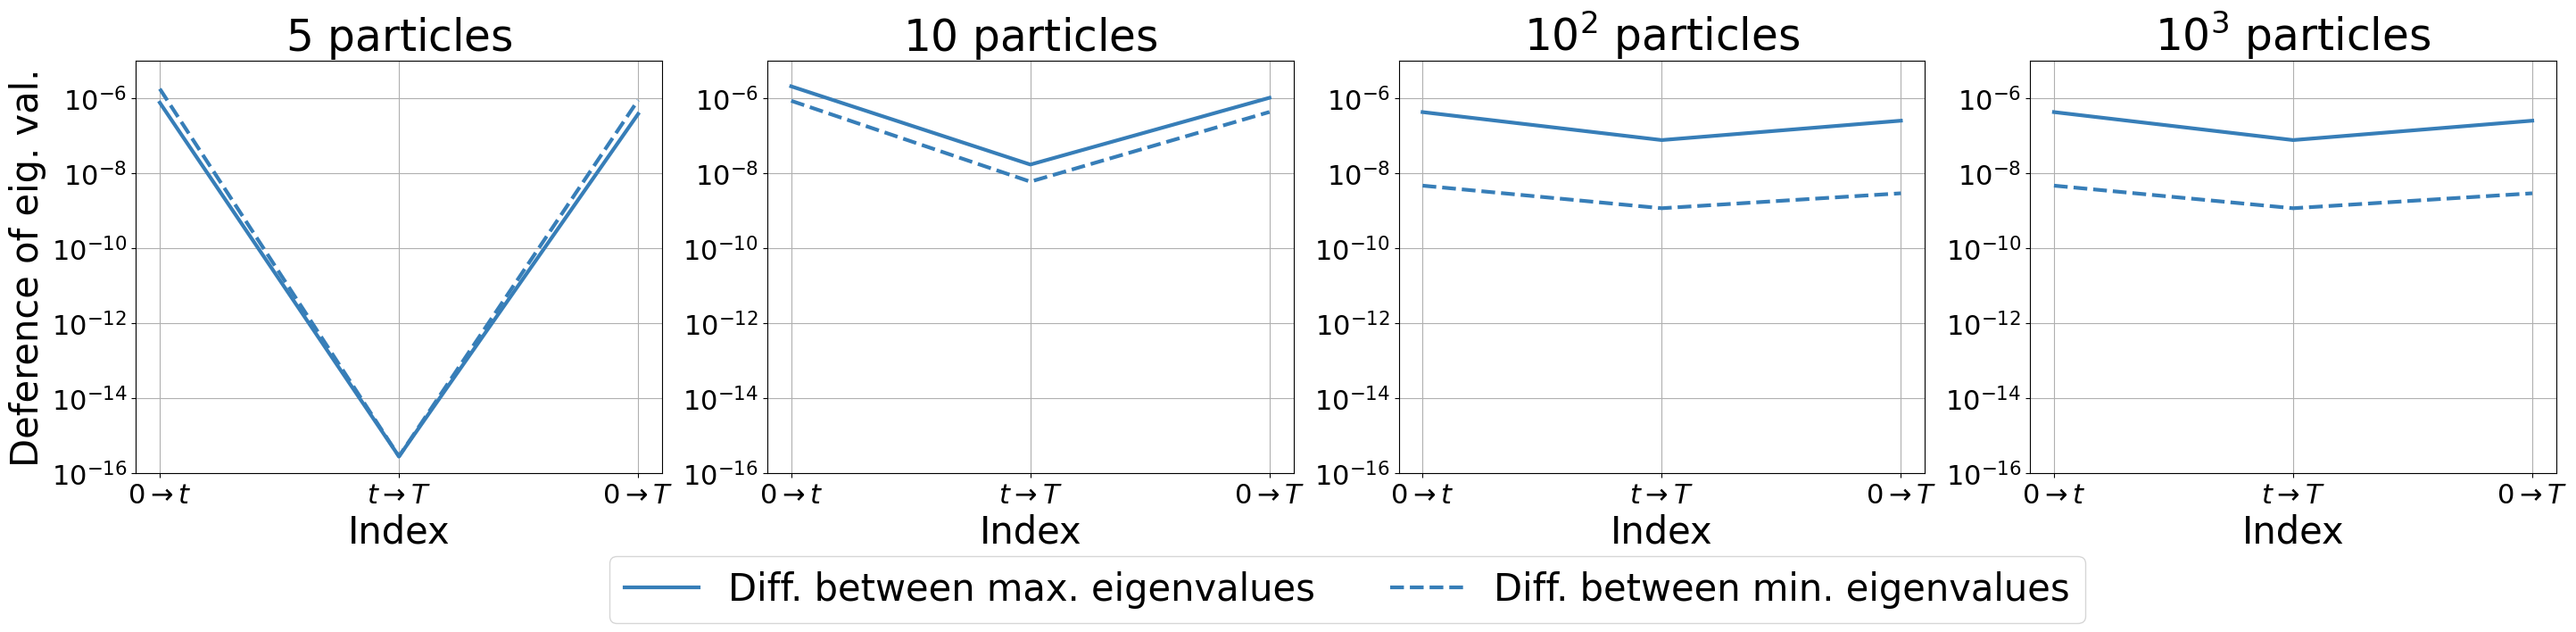

In [15]:
plt.figure(figsize=(35,6))

plt.subplot(1,4,1)
particles_list = [r'$0 \rightarrow t$', r'$t \rightarrow T$', r'$0 \rightarrow T$']
x = range(len(particles_list))
p = eig_rbf_5[0].shape

plt.plot(eig_diff(e_5),c='#377eb8', linewidth=3)
plt.plot(eig_diff(e_5_min),linestyle='--',c='#377eb8', linewidth=3)

plt.yscale('log')
#plt.xscale('log')
plt.xticks(x, particles_list, rotation=0)
plt.grid(True)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim(10**-16, 10**-5)
plt.xlabel('Index',fontsize=30)
plt.ylabel('Deference of eig. val.',fontsize=30)
plt.title('$5$ particles',fontsize=35)

plt.subplot(1,4,2)
p = eig_rbf_10[0].shape


plt.plot(eig_diff(e_10),c='#377eb8', linewidth=3)
plt.plot(eig_diff(e_10_min),linestyle='--',c='#377eb8', linewidth=3)

plt.yscale('log')
#plt.xscale('log')
plt.xticks(x, particles_list, rotation=0)
plt.grid(True)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim(10**-16, 10**-5)
plt.xlabel('Index',fontsize=30)
plt.title('$10$ particles',fontsize=35)

plt.subplot(1,4,3)

plt.plot(eig_diff(e_100),c='#377eb8', linewidth=3)
plt.plot(eig_diff(e_100_min),linestyle='--',c='#377eb8', linewidth=3)

plt.yscale('log')
#plt.xscale('log')
plt.grid(True)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim(10**-16, 10**-5)
plt.xlabel('Index',fontsize=30)
plt.title('$10^{2}$ particles',fontsize=35)
plt.xticks(x, particles_list, rotation=0)

plt.subplot(1,4,4)

plt.plot(eig_diff(e_100),c='#377eb8', linewidth=3, label='Diff. between max. eigenvalues')
plt.plot(eig_diff(e_100_min),linestyle='--',c='#377eb8', linewidth=3, label='Diff. between min. eigenvalues')
plt.yscale('log')
#plt.xscale('log')
plt.grid(True)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xticks(x, particles_list, rotation=0)
plt.ylim(10**-16, 10**-5)
plt.xlabel('Index',fontsize=30)
plt.title('$10^{3}$ particles',fontsize=35)
plt.legend(bbox_to_anchor=(-2.7, -0.2), loc='upper left', borderaxespad=0, fontsize=30, ncol = 2)